# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 0        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 18     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds = 15    # number of CV folds
    data_pl   = 0.01  # False or percentage of appended pseudo-labeled data 
    
    # wave transformation
    transform = 'cwt'   # wave transform type ['q', 's', 'cwt']
    q_sr      = 2048
    q_fmin    = 20
    q_fmax    = 1024
    q_hop     = 32
    q_bins    = 16
    
    # image processing
    channels    = 3
    p_transpose = 0                 # prob. of transpose
    p_flip       = 0                 # prob. of  vertical and horizontal flips 
    p_aug       = 0                 # prob. of augmentations except for flips
    ssr         = [0.10, 0.10, 360] # shift, scale, rotation limits
    huesat      = [0, 0, 0]         # hue, saturation, value limits
    bricon      = [0, 0]            # brightness, contrast limits
    blur_limit  = 0                 # blur limit
    cutmix      = [0, 1]            # cutmix batch-level probability, alpha
    normalize   = False             # pixel normalization after augmentation
        
    # architecture
    backbone   = 'tf_efficientnet_b7_ns'  # CNN backbone   
    pretrained = 'imagenet'             # pretrained weights [False, 'imagenet', path]
    
    # training
    num_epochs    = 7      # no. epochs per fold
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_size    = 50     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    use_fp16      = True   # mixed precision mode 
    grad_clip     = False  # max gradient norm (False or float)
    batch_verbose = False  # print loss every n batches
    
    # loss function
    loss_fn = 'BCE'  # loss ['BCE', 'FC']
    smooth  = False  # label smoothing (False or float)
    
    # LR and optimizer
    lr    = 5e-4       # starting learning rate
    optim = 'madgrad'  # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    decay = 0          # weight decay of optimizer (L2 regularization)

    # scheduler
    warmup       = 1         # no. epochs for warmup
    scheduler    = 'cosine'  # LR scheduler after warmup
    upd_on_batch = True      # update LR after every batch (or epoch)
    
    # inference
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 256   # no. images per batch 
    num_tta          = 1     # no. TTA flips (between 1 and 8)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade -U albumentations
    !pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/seti-code')  

# utilities
from utilities import *

# visualization
from sample_batch import sample_batch

# training and inference
from run_training import run_training
from run_inference import run_inference

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/seti-breakthrough-listen/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token             = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZjVlMTZiZS1kYjcyLTRmZmQtYjJhYS0xMmIyYzdiNzFkMzcifQ==',
                 project_qualified_name = 'ml_comps/g2net')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/g2net/e/GNET-88


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')        # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'training_labels.csv')
df['file_path'] = df['id'].apply(lambda x: get_train_file_path(x, CFG))

# update info
CFG['num_classes'] = df['target'].nunique()
print('no. classes: {}'.format(CFG['num_classes']))

# partitioning
folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'])
for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target'])):
    df.loc[val_idx, 'fold'] = int(fold_idx)
df['fold'] = df['fold'].astype(int)

# display
print(f'train shape: {df.shape}')
pd.crosstab(df['fold'], df['target'])

no. classes: 2
train shape: (560000, 4)


target,0,1
fold,,
0,18672,18662
1,18672,18662
2,18672,18662
3,18672,18662
4,18672,18662
5,18671,18662
6,18671,18662
7,18671,18662
8,18671,18662


In [10]:
###### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'sample_submission.csv')
sub['file_path'] = sub['id'].apply(lambda x: get_test_file_path(x, CFG))

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print(f'test shape: {sub.shape}')
display(sub.head())

test shape: (226000, 3)


,id,target,file_path
0,00005bced6,0.5,../input/test/0/0/0/00005bced6.npy
1,0000806717,0.5,../input/test/0/0/0/0000806717.npy
2,0000ef4fe1,0.5,../input/test/0/0/0/0000ef4fe1.npy
3,00020de251,0.5,../input/test/0/0/0/00020de251.npy
4,00024887b5,0.5,../input/test/0/0/0/00024887b5.npy


In [11]:
###### PSEUDO-LABELED DATA

if CFG['data_pl']:

    # import
    df_pl         = pd.read_csv(CFG['data_path'] + 'submission.csv')
    df_pl         = df_pl.merge(sub[['id', 'file_path']], how = 'left')
    df_pl['fold'] = 15

    # filter confident predictions
    df_pl = df_pl.loc[(df_pl['target'] >= df_pl['target'].quantile(1 - CFG['data_pl'])) | (df_pl['target'] <= df_pl['target'].quantile(CFG['data_pl']))].reset_index(drop = True)
    df_pl['target'] = df_pl['target'].round().astype('int')
    
    # check classes
    display(pd.crosstab(df_pl['fold'], df_pl['target']))
    
    # merge with train
    df = pd.concat([df, df_pl], axis = 0).reset_index(drop = True)
    
    # display
    print(f'train shape: {df.shape}')
    display(pd.crosstab(df['fold'], df['target']))

target,0,1
fold,,
15,2260,17150


train shape: (579410, 4)


target,0,1
fold,,
0,18672,18662
1,18672,18662
2,18672,18662
3,18672,18662
4,18672,18662
5,18671,18662
6,18671,18662
7,18671,18662
8,18671,18662


- setting random seed to 10627...
- loading time: 0.4683 vs 0.4892 seconds
- inputs shape: torch.Size([3, 3, 297, 512]) vs torch.Size([3, 3, 297, 512])
- pixel values: 0.00 | 0.18 | 1.00 vs 0.00 | 0.18 | 1.00


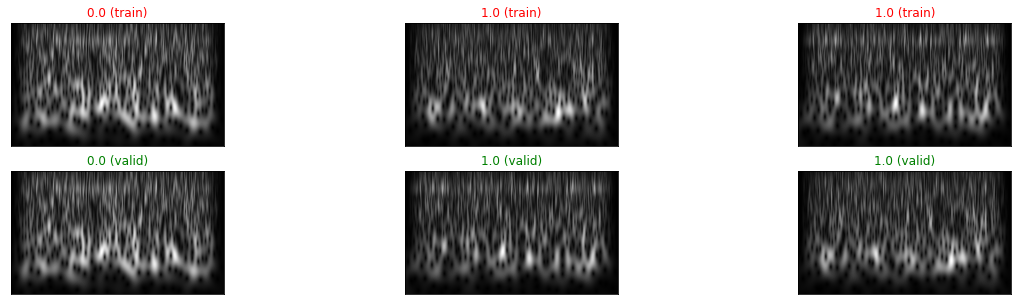

In [12]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 3, batch_idx = 1)

# 4. CROSS-VALIDATION

In [13]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (CFG, df),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
FOLD 1/15
-------------------------------------------------------
- no. images: train - 542076, valid - 37334
- setting random seed to 10627...
-  p(augment): 0
-------------------------------------------------------


  0%|          | 0/10842 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

-- epoch 1/7 | lr = 0.000500 | trn_loss = 0.4208 | val_loss = 0.4180 | val_auc = 0.8645 | 263.51 min


  0%|          | 0/10842 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

-- epoch 2/7 | lr = 0.000485 | trn_loss = 0.4002 | val_loss = 0.4152 | val_auc = 0.8686 | 256.48 min


  0%|          | 0/10842 [00:00<?, ?it/s]

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

  0%|          | 0/146 [00:00<?, ?it/s]

-- epoch 3/7 | lr = 0.000442 | trn_loss = 0.3928 | val_loss = 0.4105 | val_auc = 0.8697 | 256.83 min


  0%|          | 0/10842 [00:00<?, ?it/s]

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

  0%|          | 0/146 [00:00<?, ?it/s]

-- epoch 4/7 | lr = 0.000375 | trn_loss = 0.3874 | val_loss = 0.4077 | val_auc = 0.8712 | 257.85 min


  0%|          | 0/10842 [00:00<?, ?it/s]

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/home/RDC/kozodoin4.hub/.conda/envs/py3/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_resul

  0%|          | 0/146 [00:00<?, ?it/s]

-- epoch 5/7 | lr = 0.000293 | trn_loss = 0.3813 | val_loss = 0.4101 | val_auc = 0.8689 | 256.97 min


  0%|          | 0/10842 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 5. INFERENCE

In [14]:
from utilities import *
from model import get_model
from data import get_data, get_loaders
from augmentations import get_augs
from test_epoch import test_epoch

import gc
import neptune
from accelerate import Accelerator, DistributedType
import pandas as pd
import numpy as np



def run_inference(df, df_test, CFG):
    
    '''
    Run inference loop
    '''
        
    # placeholders
    oof = None
    sub = None
    
    # inference
    for fold in range(1):
        
        # initialize accelerator
        accelerator = Accelerator(device_placement = True,
                                  fp16             = CFG['use_fp16'],
                                  split_batches    = False)
        if CFG['device'] == 'GPU':
            accelerator.state.device = torch.device('cuda:{}'.format(CFG['device_index']))

        # feedback
        accelerator.print('-' * 55)
        accelerator.print('FOLD {:d}/{:d}'.format(fold + 1, CFG['num_folds']))    
        accelerator.print('-' * 55)   
        
        # get data
        df_trn, df_val = get_data(df, fold, CFG, accelerator, silent = True)  

        # get test loader
        _, val_loader  = get_loaders(df_trn, df_val,  CFG, accelerator, labeled = False, silent = True) 
        _, test_loader = get_loaders(df_trn, df_test, CFG, accelerator, labeled = False, silent = True) 
        
        # prepare model
        model = get_model(CFG, pretrained = CFG['out_path'] + 'weights_fold{}.pth'.format(int(fold)))
        
        # handle device placement
        model, val_loader, test_loader = accelerator.prepare(model, val_loader, test_loader)
        
        # inference for validation data
        if CFG['predict_oof']:
                        
            # produce OOF preds
            val_preds = test_epoch(loader      = val_loader, 
                                   model       = model,
                                   CFG         = CFG,
                                   accelerator = accelerator,
                                   num_tta     = CFG['num_tta'])
            
            # store OOF preds
            val_preds_df = pd.DataFrame(val_preds, columns = ['pred'])
            val_preds_df = pd.concat([df_val, val_preds_df], axis = 1)
            oof          = pd.concat([oof,    val_preds_df], axis = 0).reset_index(drop = True)
                    
        # inference for test data
        if CFG['predict_test']:
            
            # produce test preds
            test_preds = test_epoch(loader      = test_loader, 
                                    model       = model,
                                    CFG         = CFG,
                                    accelerator = accelerator,
                                    num_tta     = CFG['num_tta'])
        
            # store test preds
            test_preds_df = pd.DataFrame(test_preds, columns = ['pred_fold{}'.format(int(fold))])
            sub           = pd.concat([sub, test_preds_df], axis = 1)
            
        # clear memory
        del model, val_loader, test_loader
        del accelerator
        gc.collect()
        
    # export OOF preds
    if CFG['predict_oof']:
        oof.to_csv(CFG['out_path'] + 'oof.csv', index = False)
        if CFG['tracking']:
            neptune.send_artifact(CFG['out_path'] + 'oof.csv')
            
    # export test preds
    if CFG['predict_test']:
        sub = pd.concat([df_test['id'], sub], axis = 1)
        sub.to_csv(CFG['out_path'] + 'submission.csv', index = False)
        if CFG['tracking']:
            neptune.send_artifact(CFG['out_path'] + 'submission.csv')

In [15]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
FOLD 1/15
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/883 [00:00<?, ?it/s]


Finished in 32.85 minutes


In [ ]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for fold in range(CFG['num_folds']):
    oof_score.append(get_score(oof.loc[oof['fold'] == fold, 'target'],
                               oof.loc[oof['fold'] == fold, 'pred']))
CFG['oof_score_tta'] = np.mean(oof_score)

# print performance
print('-' * 30)
print('OOF with TTA = {:.4f}'.format(CFG['oof_score_tta']))
print('-' * 30)

In [ ]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score_tta', CFG['oof_score_tta'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()

# 7. ERROR ANALYSIS

In [ ]:
###### SHOW SAMPLE PREDICTIONS

from plot_predictions import plot_predictions
plot_predictions(CFG, fold = 0, sample_size = 5)